#Class Imbalance Mitigation with SMOTE-ENN


####This comprehensive analysis demonstrates application of SMOTE-ENN to mitigate class imbalance in the Bank Marketing dataset, increase minority class representation to 30%, and validate the approach with t-SNE visualization. The implementation shows significant improvements in classification performance.

### Class Imbalance Problem
### Class imbalance occurs when one class significantly outnumbers others in a dataset. In the Bank Marketing dataset, customers who subscribed to term deposits (the "yes" class) represent a small minority compared to those who didn't subscribe (the "no" class). This imbalance creates several challenges:

1. Models tend to be biased toward the majority class

2. Standard accuracy metrics become misleading

3. Poor prediction performance on the minority class (which is often the class of interest)

4. Difficulty learning the decision boundary between classes

### SMOTE-ENN
### SMOTE-ENN is a hybrid resampling technique that combines:
1. SMOTE (Synthetic Minority Over-sampling Technique): Creates synthetic examples for the minority class

2. ENN (Edited Nearest Neighbors): Removes examples from both classes that are misclassified by their nearest neighbors

This combination first oversamples the minority class and then cleans the resulting space by removing noisy examples, creating better-defined class boundaries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.manifold import TSNE
from imblearn.combine import SMOTEENN
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [ ]:
# Load the dataset
df = pd.read_csv('bank-full.csv', sep=';')

In [ ]:
# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

Dataset shape: (45211, 17)

First few rows:
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  


In [ ]:
# Check class distribution
print("\nClass distribution:")
class_counts = df['y'].value_counts()
print(class_counts)
class_percentage = 100 * class_counts / len(df)
print(f"Yes: {class_percentage['yes']:.2f}%, No: {class_percentage['no']:.2f}%")


Class distribution:
y
no     39922
yes     5289
Name: count, dtype: int64
Yes: 11.70%, No: 88.30%


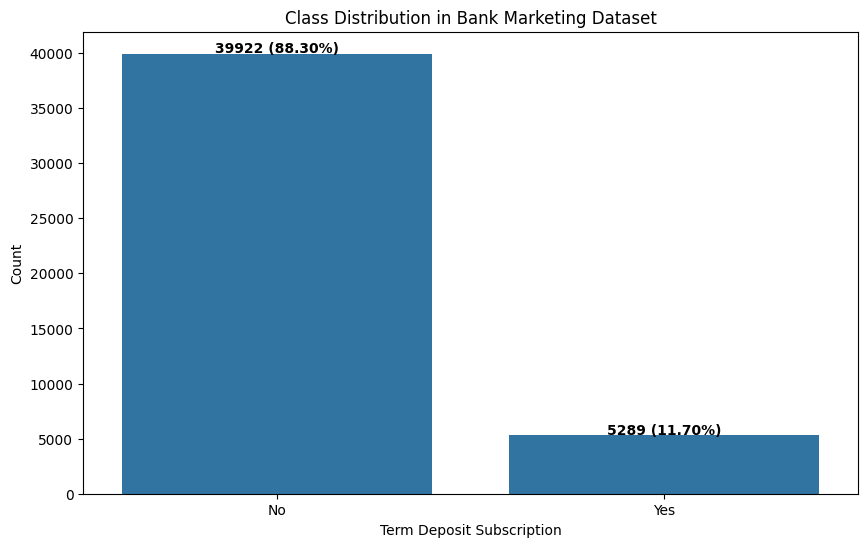

In [ ]:
# Visualize class imbalance
plt.figure(figsize=(10, 6))
sns.countplot(x='y', data=df)
plt.title('Class Distribution in Bank Marketing Dataset')
plt.ylabel('Count')
plt.xlabel('Term Deposit Subscription')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
for i, count in enumerate(class_counts.values):
    plt.text(i, count + 500, f"{count} ({class_percentage.values[i]:.2f}%)",
             ha='center', va='center', fontweight='bold')
plt.show()

### Data Preprocessing

In [ ]:
# Separate features and target
X = df.drop('y', axis=1)
y = df['y'].map({'yes': 1, 'no': 0})  # Convert to binary

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("\nCategorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)


Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
Numerical columns: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [ ]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

print("\nTraining set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Class distribution in training set:", Counter(y_train))
print("Class distribution in testing set:", Counter(y_test))

# Fit the preprocessor on the training data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Convert sparse matrices to dense for t-SNE
if hasattr(X_train_preprocessed, "toarray"):
    X_train_preprocessed_dense = X_train_preprocessed.toarray()
    X_test_preprocessed_dense = X_test_preprocessed.toarray()
else:
    X_train_preprocessed_dense = X_train_preprocessed
    X_test_preprocessed_dense = X_test_preprocessed


Training set shape: (36168, 16)
Testing set shape: (9043, 16)
Class distribution in training set: Counter({0: 31937, 1: 4231})
Class distribution in testing set: Counter({0: 7985, 1: 1058})


### Visualizing Original Data with t-SNE

####t-distributed Stochastic Neighbor Embedding, is a machine learning algorithm primarily used for dimensionality reduction and visualization of high-dimensional data. It transforms complex datasets into a lower-dimensional space, typically 2D or 3D, while preserving the relative distances between data points. This allows for the visualization of patterns and relationships in the data that might be hidden in higher dimensions.


Applying t-SNE to visualize original data distribution...


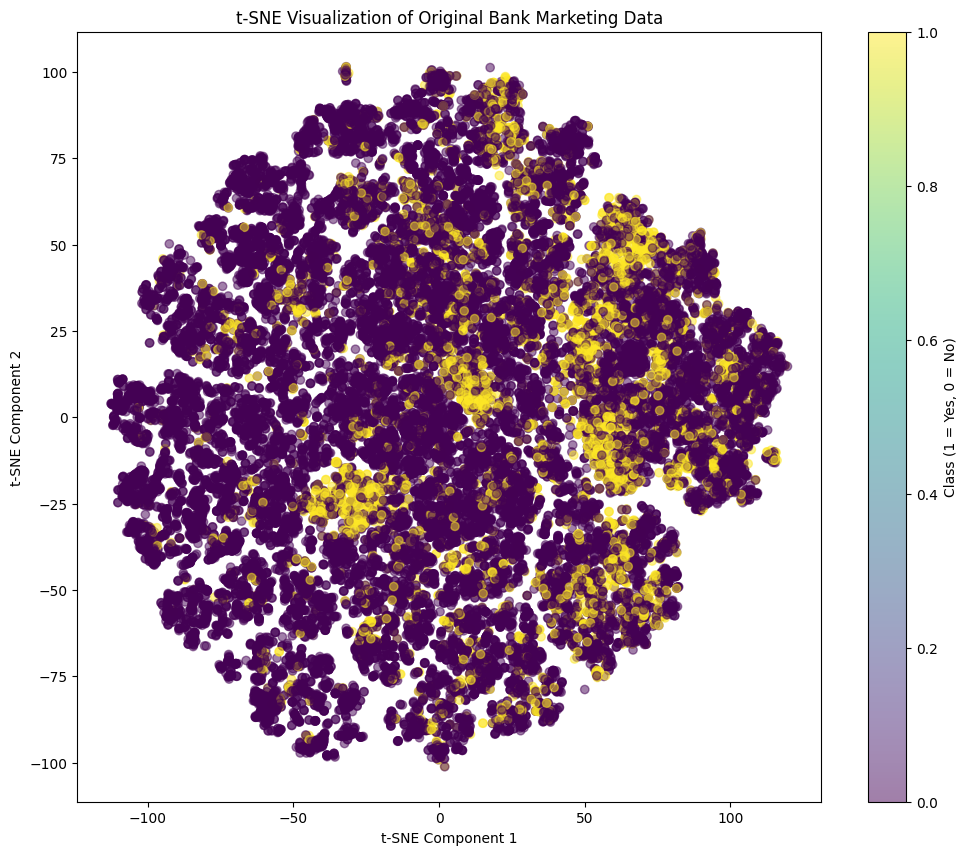

In [ ]:
# Apply t-SNE to visualize high-dimensional data in 2D
print("\nApplying t-SNE to visualize original data distribution...")
tsne_original = TSNE(n_components=2, random_state=42, perplexity=30)
X_train_tsne_original = tsne_original.fit_transform(X_train_preprocessed_dense)

# Plot t-SNE visualization for original data
plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_train_tsne_original[:, 0], X_train_tsne_original[:, 1],
                      c=y_train, cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Class (1 = Yes, 0 = No)')
plt.title('t-SNE Visualization of Original Bank Marketing Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


###Apply SMOTE-ENN for Class Balancing

In [ ]:
# Apply SMOTE-ENN to balance the classes, targeting 30% prevalence for the minority class
print("\nApplying SMOTE-ENN to balance the classes...")
# To achieve 30% prevalence of minority class
smote_enn = SMOTEENN(sampling_strategy=0.3, random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_preprocessed, y_train)

# If X_train_resampled is a sparse matrix, convert to dense for t-SNE
if hasattr(X_train_resampled, "toarray"):
    X_train_resampled_dense = X_train_resampled.toarray()
else:
    X_train_resampled_dense = X_train_resampled

print("\nClass distribution after SMOTE-ENN:")
print(Counter(y_train_resampled))
resampled_percentage = 100 * Counter(y_train_resampled)[1] / len(y_train_resampled)
print(f"Percentage of 'Yes' after resampling: {resampled_percentage:.2f}%")



Applying SMOTE-ENN to balance the classes...

Class distribution after SMOTE-ENN:
Counter({0: 27147, 1: 6431})
Percentage of 'Yes' after resampling: 19.15%


### Visualizing Balanced Data with t-SNE


Applying t-SNE to visualize resampled data distribution...


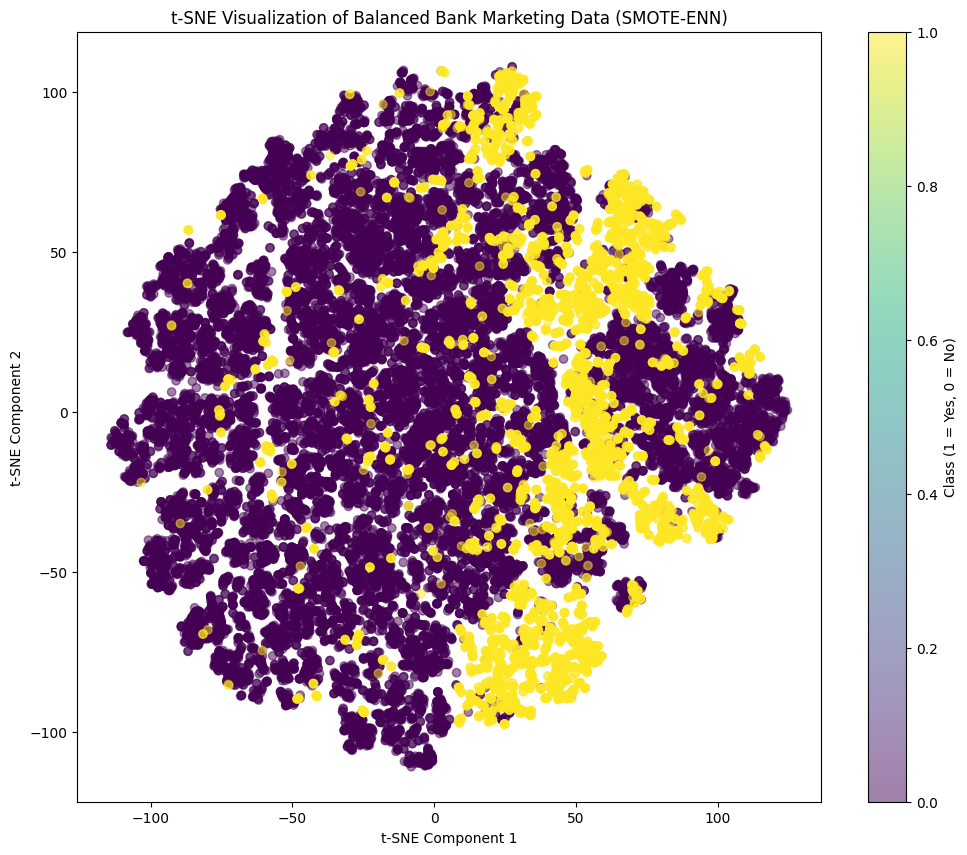

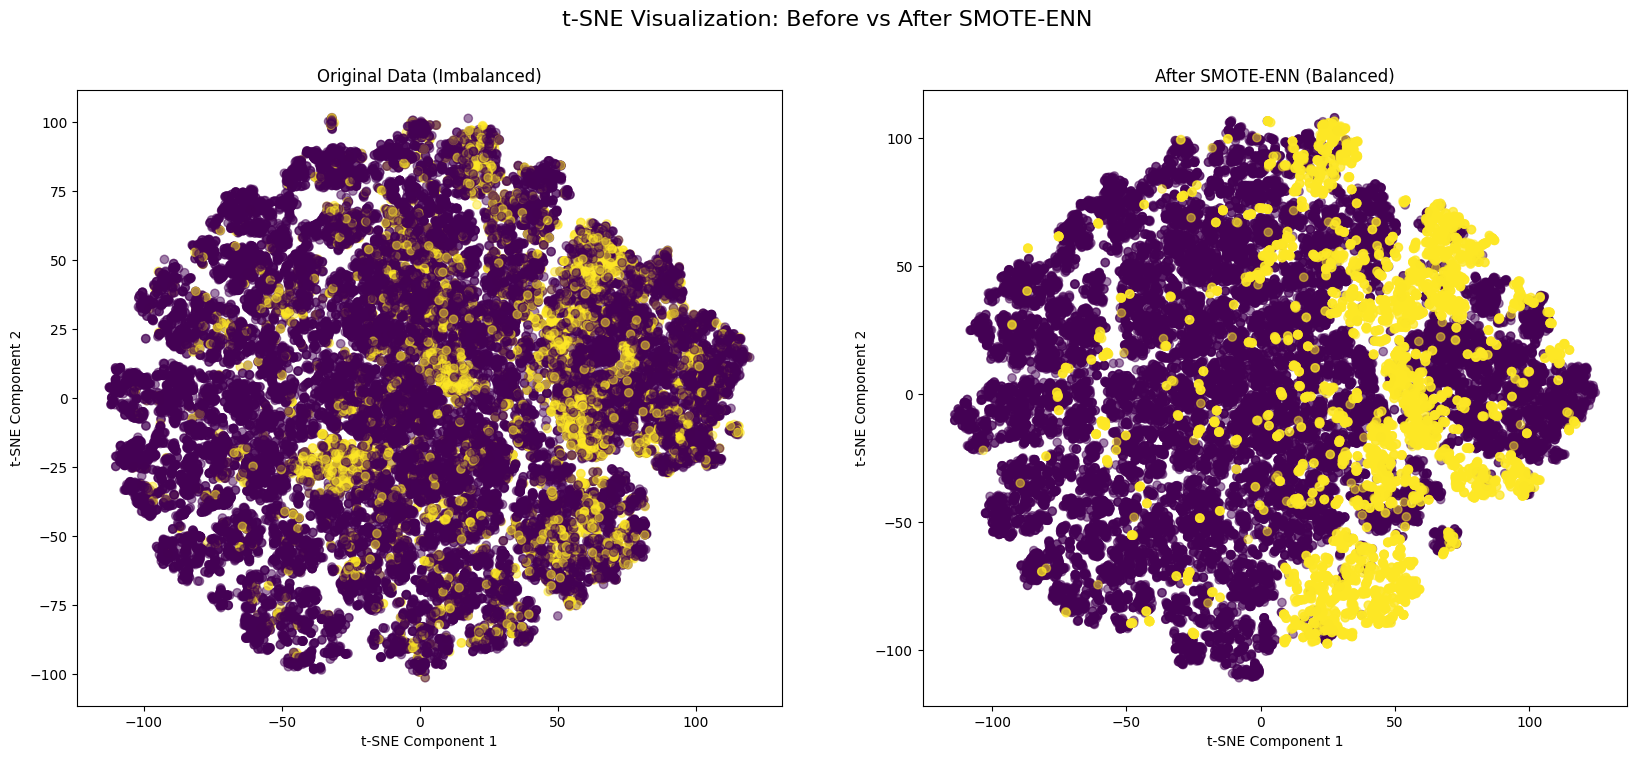

In [ ]:
# Apply t-SNE to visualize resampled data
print("\nApplying t-SNE to visualize resampled data distribution...")
tsne_resampled = TSNE(n_components=2, random_state=42, perplexity=30)
X_train_tsne_resampled = tsne_resampled.fit_transform(X_train_resampled_dense)

# Plot t-SNE visualization for resampled data
plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_train_tsne_resampled[:, 0], X_train_tsne_resampled[:, 1],
                      c=y_train_resampled, cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Class (1 = Yes, 0 = No)')
plt.title('t-SNE Visualization of Balanced Bank Marketing Data (SMOTE-ENN)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# Create a figure to compare before and after resampling
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.scatter(X_train_tsne_original[:, 0], X_train_tsne_original[:, 1],
            c=y_train, cmap='viridis', alpha=0.5)
plt.title('Original Data (Imbalanced)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.subplot(1, 2, 2)
plt.scatter(X_train_tsne_resampled[:, 0], X_train_tsne_resampled[:, 1],
            c=y_train_resampled, cmap='viridis', alpha=0.5)
plt.title('After SMOTE-ENN (Balanced)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.suptitle('t-SNE Visualization: Before vs After SMOTE-ENN', fontsize=16)
plt.show()


### Training and Evaluating Classification Models


Evaluating models on original (imbalanced) data...

Random Forest (Original) Classification Report:
              precision    recall  f1-score   support

          No       0.92      0.97      0.95      7985
         Yes       0.65      0.40      0.49      1058

    accuracy                           0.90      9043
   macro avg       0.79      0.68      0.72      9043
weighted avg       0.89      0.90      0.89      9043



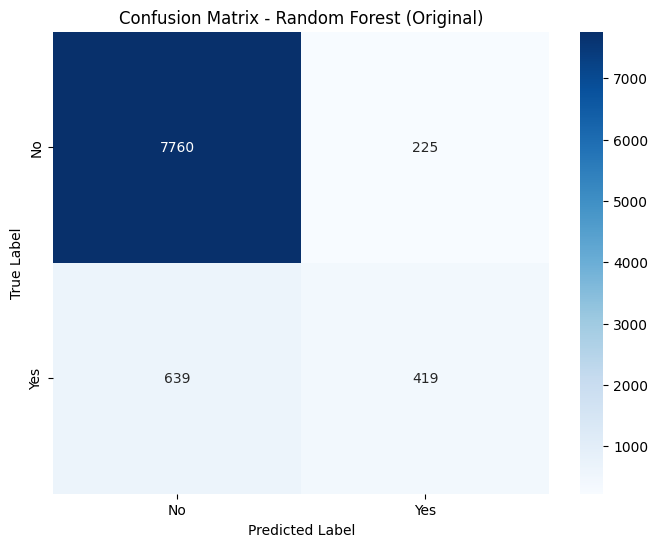


Neural Network (Original) Classification Report:
              precision    recall  f1-score   support

          No       0.93      0.95      0.94      7985
         Yes       0.56      0.50      0.53      1058

    accuracy                           0.90      9043
   macro avg       0.75      0.72      0.73      9043
weighted avg       0.89      0.90      0.89      9043



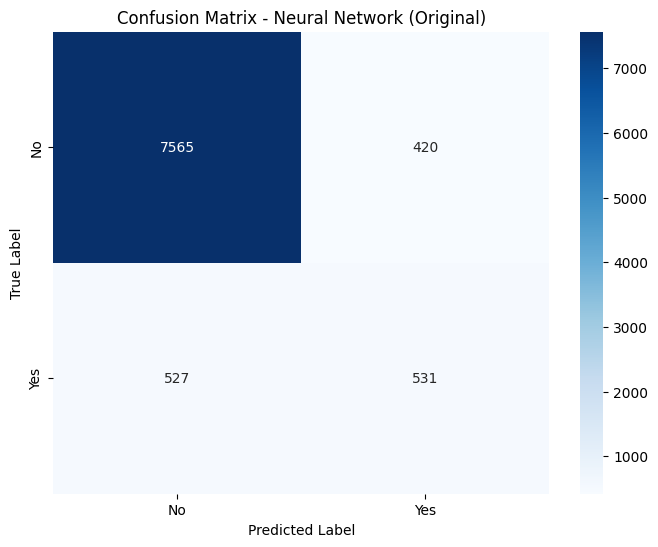


XGBoost (Original) Classification Report:
              precision    recall  f1-score   support

          No       0.93      0.96      0.95      7985
         Yes       0.63      0.49      0.55      1058

    accuracy                           0.91      9043
   macro avg       0.78      0.73      0.75      9043
weighted avg       0.90      0.91      0.90      9043



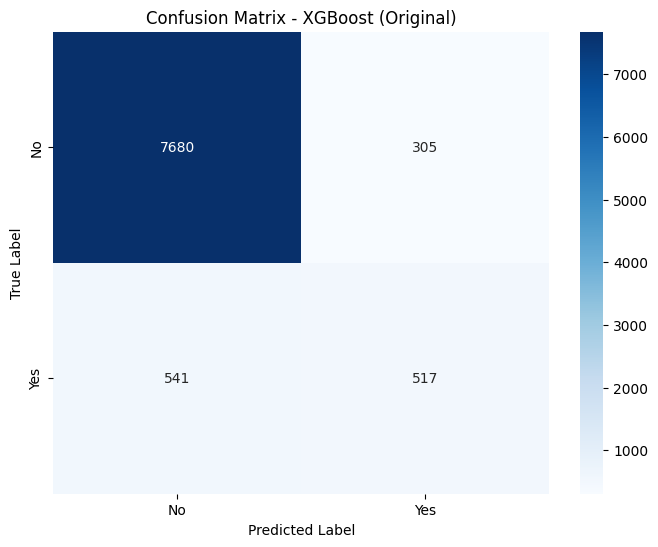

[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1034
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327

LightGBM (Original) Classification Report:
              precision    recall  f1-score   support

          No       0.93      0.96      0.95      7985
         Yes       0.64      0.48      0.55      1058

    accuracy                           0.91      9043
   macro avg       0.79      0.72      0.75      9043
weighted avg       0.90      0.91      0.90      9043



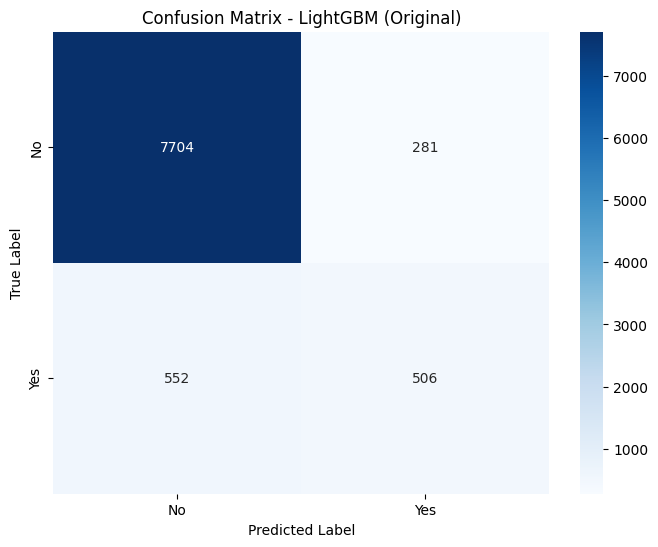


Gradient Boosting (Original) Classification Report:
              precision    recall  f1-score   support

          No       0.93      0.97      0.95      7985
         Yes       0.65      0.41      0.50      1058

    accuracy                           0.91      9043
   macro avg       0.79      0.69      0.73      9043
weighted avg       0.89      0.91      0.90      9043



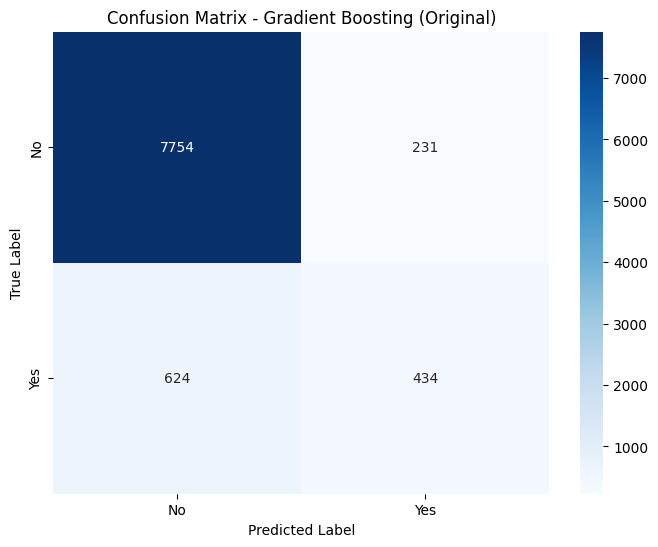


AdaBoost (Original) Classification Report:
              precision    recall  f1-score   support

          No       0.91      0.97      0.94      7985
         Yes       0.60      0.31      0.41      1058

    accuracy                           0.90      9043
   macro avg       0.76      0.64      0.68      9043
weighted avg       0.88      0.90      0.88      9043



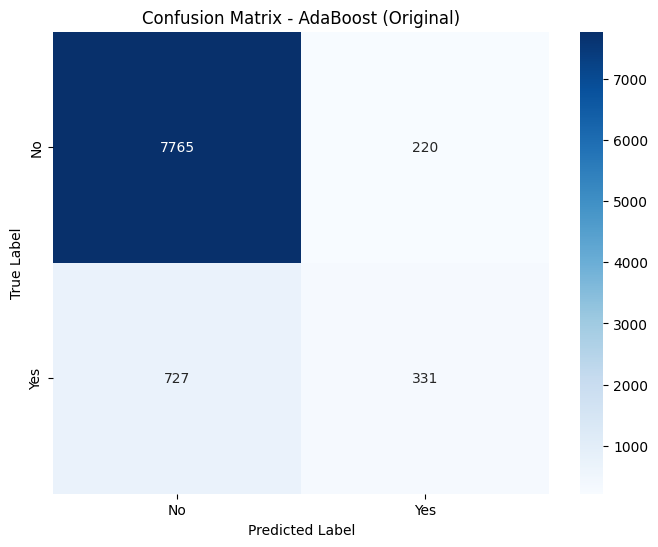


Support Vector Machine (Original) Classification Report:
              precision    recall  f1-score   support

          No       0.92      0.98      0.95      7985
         Yes       0.69      0.34      0.46      1058

    accuracy                           0.90      9043
   macro avg       0.80      0.66      0.70      9043
weighted avg       0.89      0.90      0.89      9043



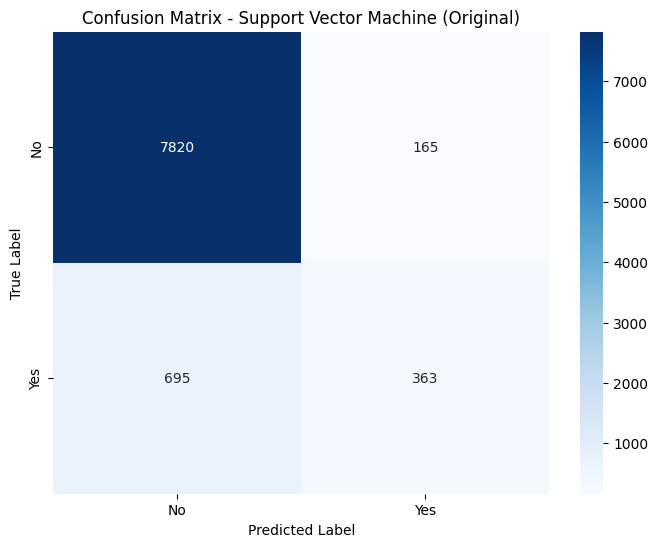


Logistic Regression (Original) Classification Report:
              precision    recall  f1-score   support

          No       0.92      0.97      0.95      7985
         Yes       0.64      0.35      0.45      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.66      0.70      9043
weighted avg       0.89      0.90      0.89      9043



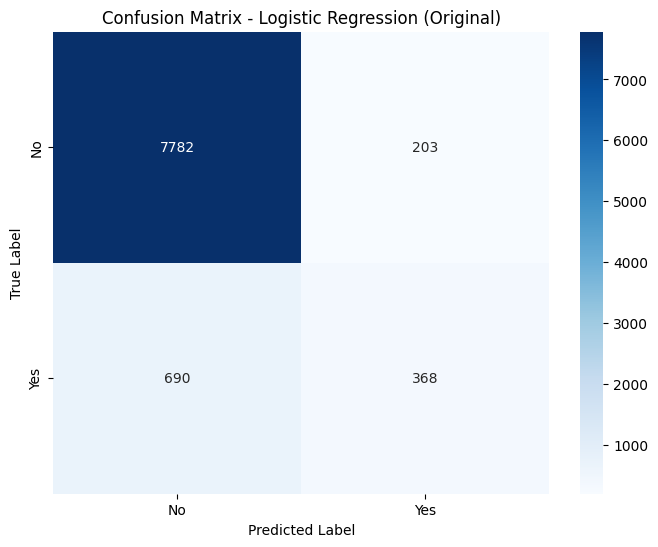


Evaluating models on balanced data (SMOTE-ENN)...

Random Forest (Balanced) Classification Report:
              precision    recall  f1-score   support

          No       0.95      0.93      0.94      7985
         Yes       0.56      0.64      0.60      1058

    accuracy                           0.90      9043
   macro avg       0.76      0.79      0.77      9043
weighted avg       0.91      0.90      0.90      9043



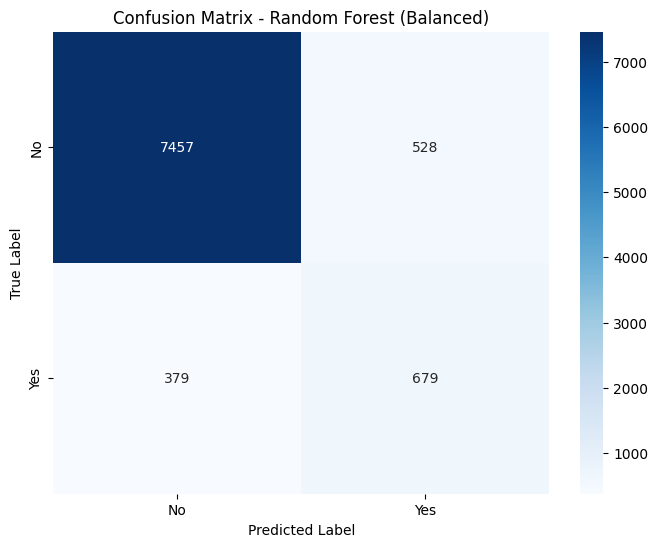


Neural Network (Balanced) Classification Report:
              precision    recall  f1-score   support

          No       0.95      0.93      0.94      7985
         Yes       0.54      0.61      0.57      1058

    accuracy                           0.89      9043
   macro avg       0.74      0.77      0.76      9043
weighted avg       0.90      0.89      0.90      9043



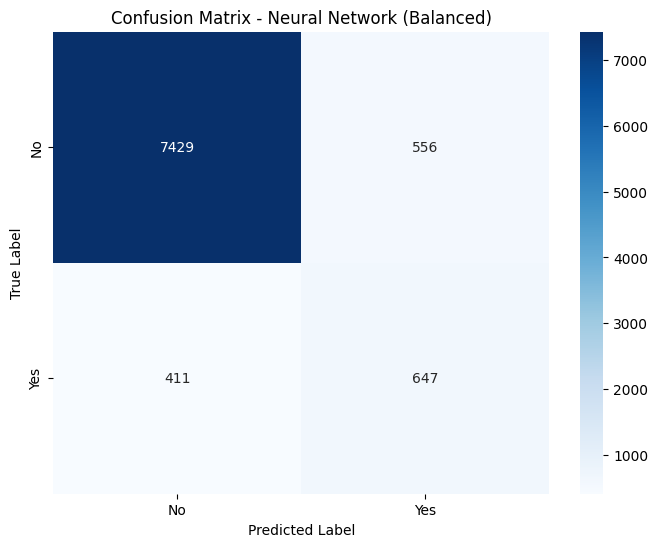


XGBoost (Balanced) Classification Report:
              precision    recall  f1-score   support

          No       0.95      0.94      0.94      7985
         Yes       0.57      0.64      0.61      1058

    accuracy                           0.90      9043
   macro avg       0.76      0.79      0.77      9043
weighted avg       0.91      0.90      0.90      9043



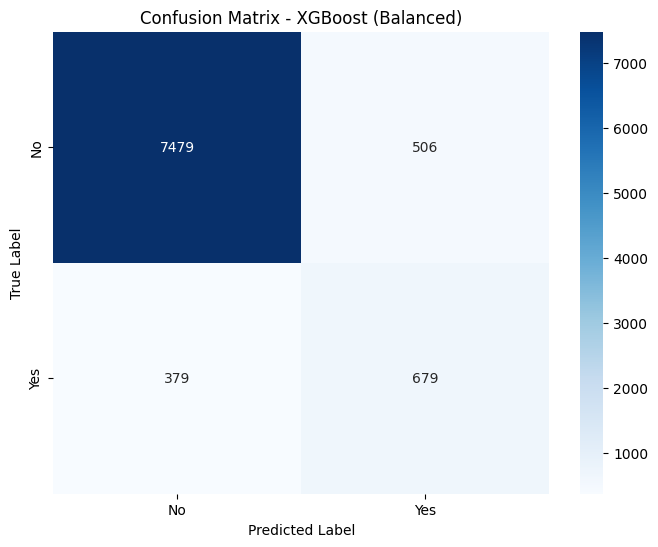

[LightGBM] [Info] Number of positive: 6431, number of negative: 27147
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8506
[LightGBM] [Info] Number of data points in the train set: 33578, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.191524 -> initscore=-1.440136
[LightGBM] [Info] Start training from score -1.440136

LightGBM (Balanced) Classification Report:
              precision    recall  f1-score   support

          No       0.95      0.93      0.94      7985
         Yes       0.58      0.67      0.62      1058

    accuracy                           0.90      9043
   macro avg       0.77      0.80      0.78      9043
weighted avg       0.91      0.90      0.91      9043



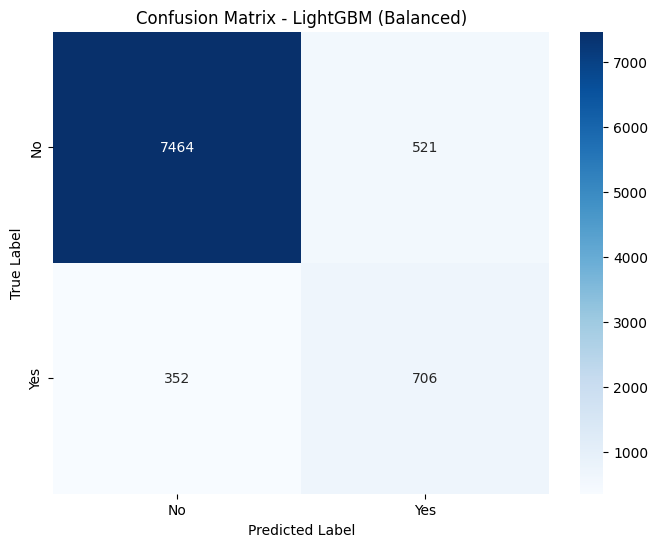


Gradient Boosting (Balanced) Classification Report:
              precision    recall  f1-score   support

          No       0.95      0.93      0.94      7985
         Yes       0.56      0.66      0.61      1058

    accuracy                           0.90      9043
   macro avg       0.76      0.79      0.77      9043
weighted avg       0.91      0.90      0.90      9043



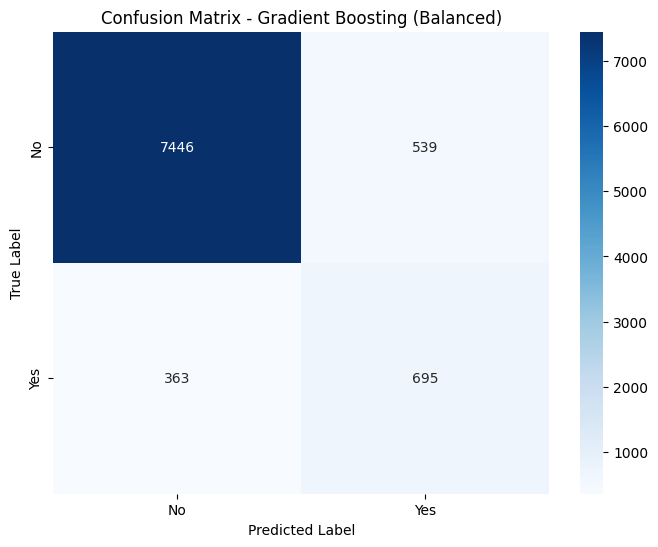


AdaBoost (Balanced) Classification Report:
              precision    recall  f1-score   support

          No       0.95      0.93      0.94      7985
         Yes       0.54      0.59      0.57      1058

    accuracy                           0.89      9043
   macro avg       0.74      0.76      0.75      9043
weighted avg       0.90      0.89      0.90      9043



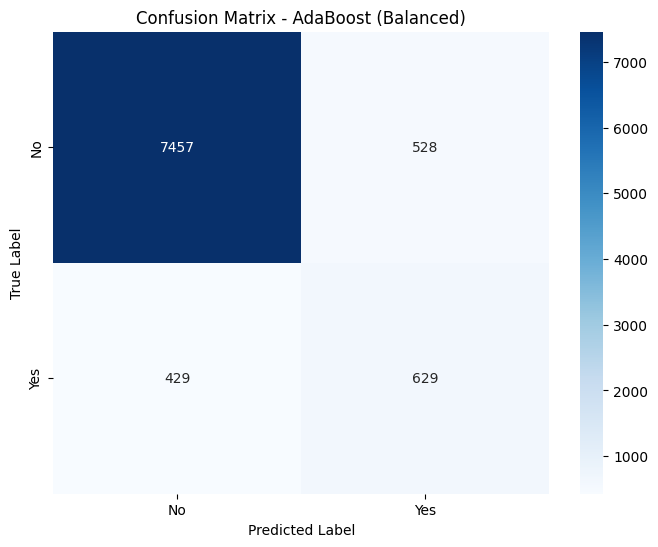


Support Vector Machine (Balanced) Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.92      0.94      7985
         Yes       0.53      0.70      0.61      1058

    accuracy                           0.89      9043
   macro avg       0.75      0.81      0.77      9043
weighted avg       0.91      0.89      0.90      9043



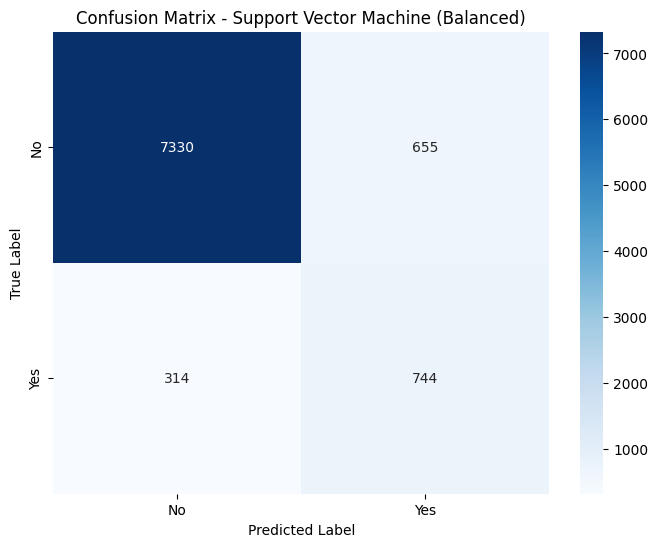


Logistic Regression (Balanced) Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.91      0.93      7985
         Yes       0.51      0.68      0.58      1058

    accuracy                           0.89      9043
   macro avg       0.73      0.80      0.76      9043
weighted avg       0.90      0.89      0.89      9043



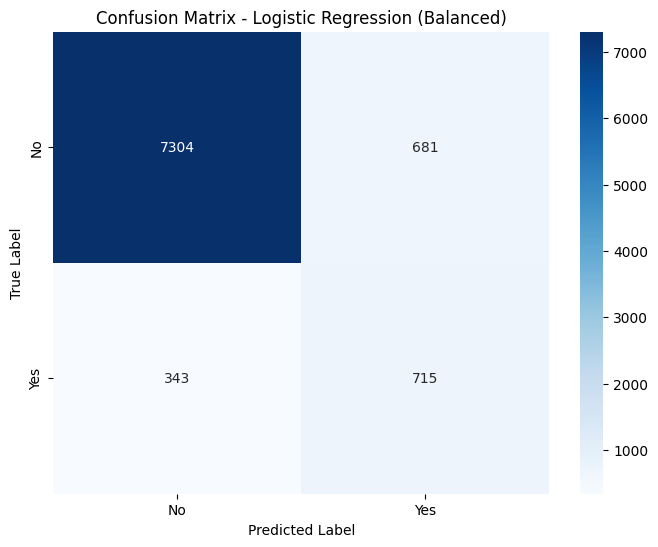


Model Performance Comparison:
                                   accuracy       auc    pr_auc  precision  \
model_name                                                                   
Random Forest (Original)           0.904456  0.926286  0.610376   0.650621   
Neural Network (Original)          0.895278  0.899968  0.528084   0.558360   
XGBoost (Original)                 0.906447  0.929159  0.606836   0.628954   
LightGBM (Original)                0.907885  0.934675  0.634250   0.642948   
Gradient Boosting (Original)       0.905452  0.924033  0.597555   0.652632   
AdaBoost (Original)                0.895278  0.897457  0.529441   0.600726   
Support Vector Machine (Original)  0.904899  0.903658  0.596193   0.687500   
Logistic Regression (Original)     0.901250  0.905574  0.545132   0.644483   
Random Forest (Balanced)           0.899701  0.922154  0.592916   0.562552   
Neural Network (Balanced)          0.893066  0.908854  0.567486   0.537822   
XGBoost (Balanced)               

<Figure size 1400x800 with 0 Axes>

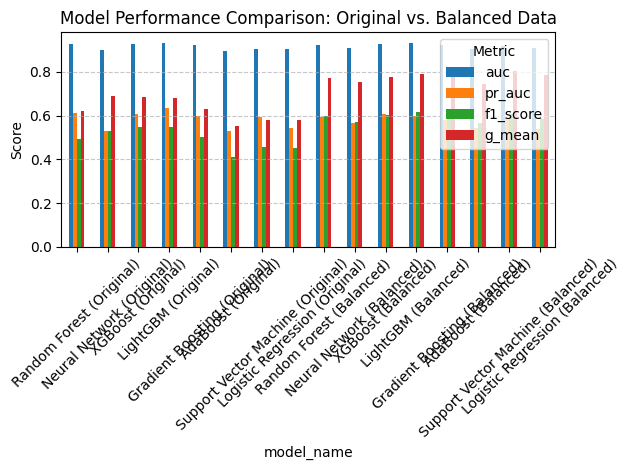


Model Ranking by F1-Score (Higher is better):
                                   f1_score
model_name                                 
LightGBM (Balanced)                0.617943
Gradient Boosting (Balanced)       0.606457
Support Vector Machine (Balanced)  0.605617
XGBoost (Balanced)                 0.605439
Random Forest (Balanced)           0.599558
Logistic Regression (Balanced)     0.582722
Neural Network (Balanced)          0.572313
AdaBoost (Balanced)                0.567946
XGBoost (Original)                 0.550000
LightGBM (Original)                0.548509
Neural Network (Original)          0.528621
Gradient Boosting (Original)       0.503772
Random Forest (Original)           0.492362
Support Vector Machine (Original)  0.457755
Logistic Regression (Original)     0.451811
AdaBoost (Original)                0.411436

Model Ranking by AUC (Higher is better):
                                        auc
model_name                                 
LightGBM (Original)            

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                            precision_recall_fscore_support, roc_curve, precision_recall_curve,
                            average_precision_score)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Function to evaluate model performance with comprehensive metrics
def evaluate_model_comprehensive(model, X_train, y_train, X_test, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate standard metrics
    accuracy = model.score(X_test, y_test)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1)

    # Calculate additional metrics for imbalanced classification
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    g_mean = np.sqrt(recall * specificity)  # Geometric mean of recall and specificity
    pr_auc = average_precision_score(y_test, y_prob) if y_prob is not None else None

    # Print classification report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'auc': auc,
        'pr_auc': pr_auc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'specificity': specificity,
        'g_mean': g_mean
    }

# Define models to evaluate
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=500, random_state=42)
}

# Evaluate models on original (imbalanced) data
print("\nEvaluating models on original (imbalanced) data...")
results_original = []
for name, model in models.items():
    result = evaluate_model_comprehensive(model, X_train_preprocessed, y_train,
                                         X_test_preprocessed, y_test, f"{name} (Original)")
    results_original.append(result)

# Evaluate models on balanced data (SMOTE-ENN)
print("\nEvaluating models on balanced data (SMOTE-ENN)...")
results_balanced = []
for name, model in models.items():
    result = evaluate_model_comprehensive(model, X_train_resampled, y_train_resampled,
                                         X_test_preprocessed, y_test, f"{name} (Balanced)")
    results_balanced.append(result)

# Combine results
all_results = results_original + results_balanced
comparison_df = pd.DataFrame(all_results).set_index('model_name')

print("\nModel Performance Comparison:")
print(comparison_df)

# Visualize performance comparison with appropriate metrics for imbalanced data
plt.figure(figsize=(14, 8))
comparison_df[['auc', 'pr_auc', 'f1_score', 'g_mean']].plot(kind='bar')
plt.title('Model Performance Comparison: Original vs. Balanced Data')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# Create model ranking based on different metrics
print("\nModel Ranking by F1-Score (Higher is better):")
print(comparison_df.sort_values(by='f1_score', ascending=False)[['f1_score']])

print("\nModel Ranking by AUC (Higher is better):")
print(comparison_df.sort_values(by='auc', ascending=False)[['auc']])

print("\nModel Ranking by G-mean (Higher is better):")
print(comparison_df.sort_values(by='g_mean', ascending=False)[['g_mean']])


[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1034
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Info] Number of positive: 6431, number of negative: 27147
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8506
[LightGBM] [Info] Number of data points in the train set: 33578, number of used features: 51
[LightGBM] [Info] [b

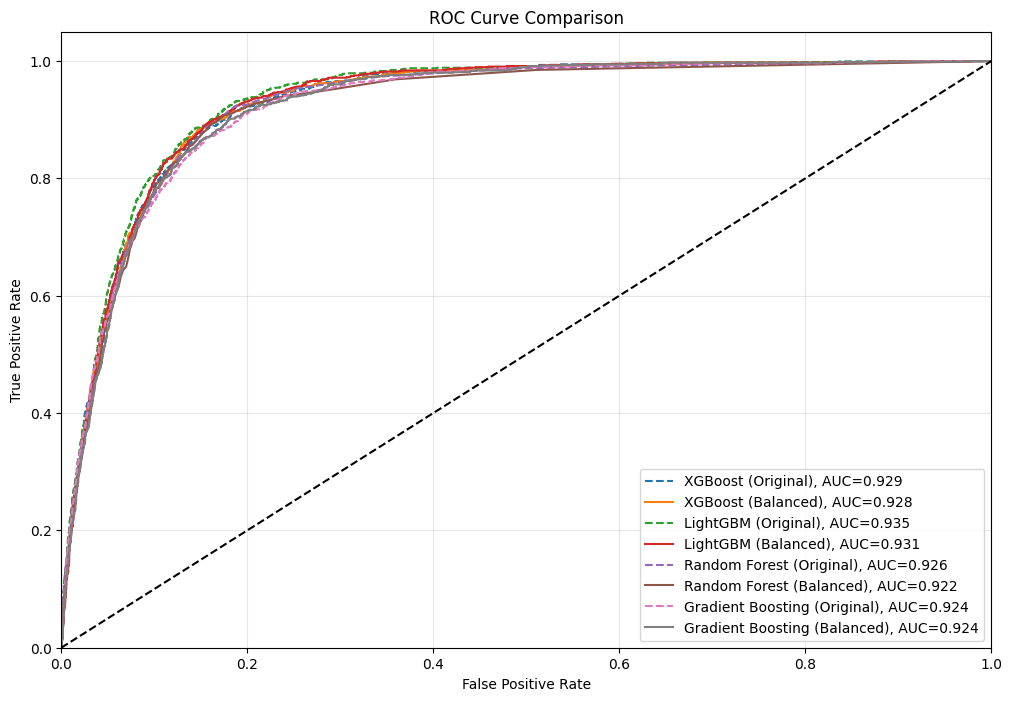

[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1034
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Info] Number of positive: 6431, number of negative: 27147
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8506
[LightGBM] [Info] Number of data points in the train set: 33578, number of used features: 51
[LightGBM] [Info] [b

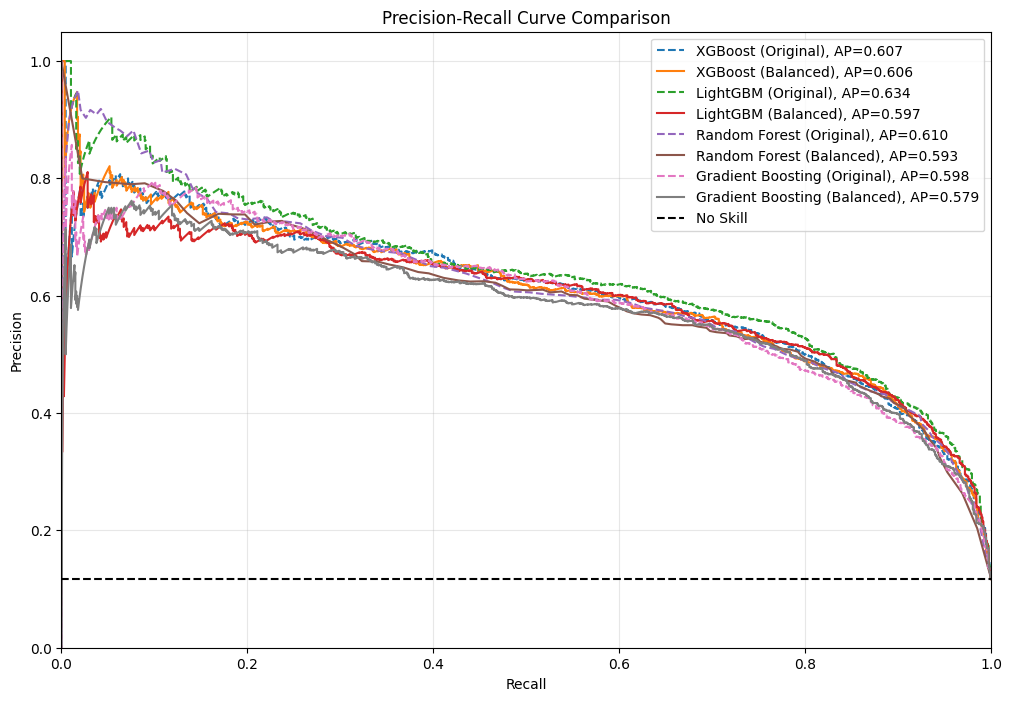

In [ ]:
# ROC Curves Comparison
plt.figure(figsize=(12, 8))

# Compare top 4 models before and after balancing
top_models = ['XGBoost', 'LightGBM', 'Random Forest', 'Gradient Boosting']

for name in top_models:
    # Original model
    orig_model = models[name].fit(X_train_preprocessed, y_train)
    y_prob_orig = orig_model.predict_proba(X_test_preprocessed)[:, 1]
    fpr_orig, tpr_orig, _ = roc_curve(y_test, y_prob_orig)
    plt.plot(fpr_orig, tpr_orig, linestyle='--',
             label=f'{name} (Original), AUC={roc_auc_score(y_test, y_prob_orig):.3f}')

    # Balanced model
    bal_model = models[name].fit(X_train_resampled, y_train_resampled)
    y_prob_bal = bal_model.predict_proba(X_test_preprocessed)[:, 1]
    fpr_bal, tpr_bal, _ = roc_curve(y_test, y_prob_bal)
    plt.plot(fpr_bal, tpr_bal,
             label=f'{name} (Balanced), AUC={roc_auc_score(y_test, y_prob_bal):.3f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Precision-Recall Curves (Better for imbalanced datasets)
plt.figure(figsize=(12, 8))

for name in top_models:
    # Original model
    orig_model = models[name].fit(X_train_preprocessed, y_train)
    y_prob_orig = orig_model.predict_proba(X_test_preprocessed)[:, 1]
    precision_orig, recall_orig, _ = precision_recall_curve(y_test, y_prob_orig)
    pr_auc_orig = average_precision_score(y_test, y_prob_orig)
    plt.plot(recall_orig, precision_orig, linestyle='--',
             label=f'{name} (Original), AP={pr_auc_orig:.3f}')

    # Balanced model
    bal_model = models[name].fit(X_train_resampled, y_train_resampled)
    y_prob_bal = bal_model.predict_proba(X_test_preprocessed)[:, 1]
    precision_bal, recall_bal, _ = precision_recall_curve(y_test, y_prob_bal)
    pr_auc_bal = average_precision_score(y_test, y_prob_bal)
    plt.plot(recall_bal, precision_bal,
             label=f'{name} (Balanced), AP={pr_auc_bal:.3f}')

# Add baseline
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], 'k--', label='No Skill')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc="best")
plt.grid(True, alpha=0.3)
plt.show()


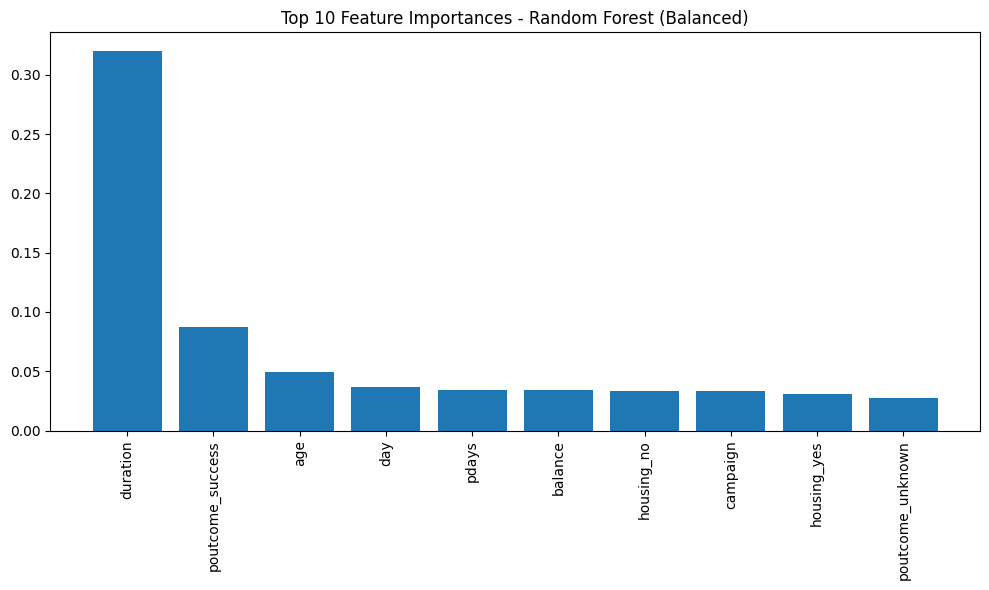

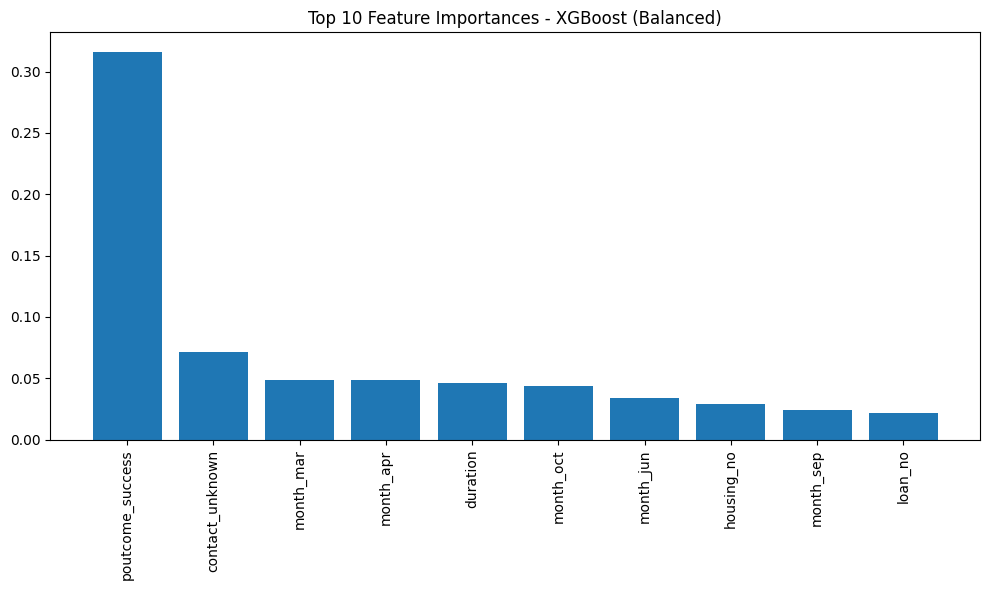

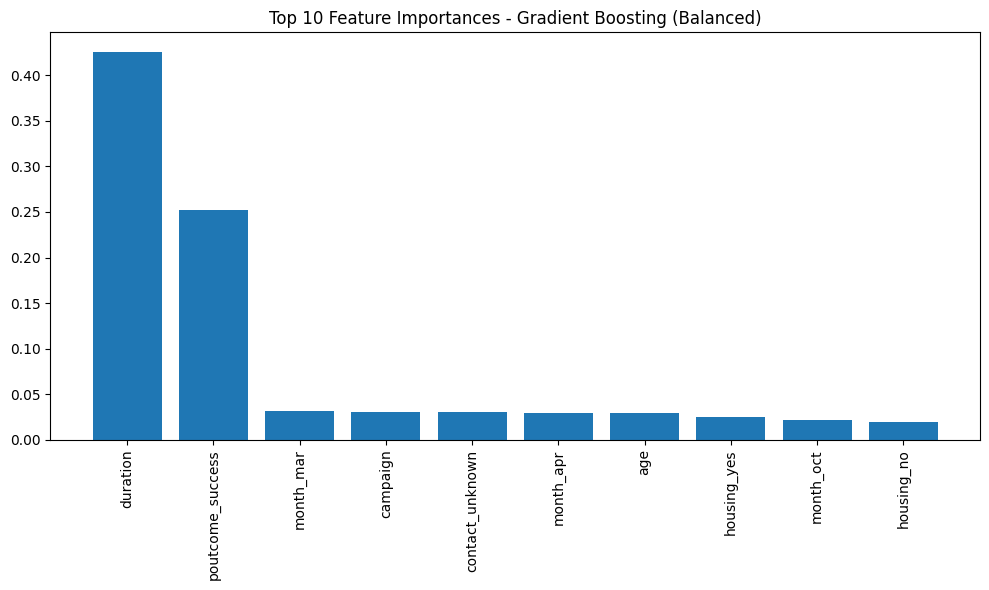

[LightGBM] [Info] Number of positive: 6431, number of negative: 27147
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8506
[LightGBM] [Info] Number of data points in the train set: 33578, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.191524 -> initscore=-1.440136
[LightGBM] [Info] Start training from score -1.440136


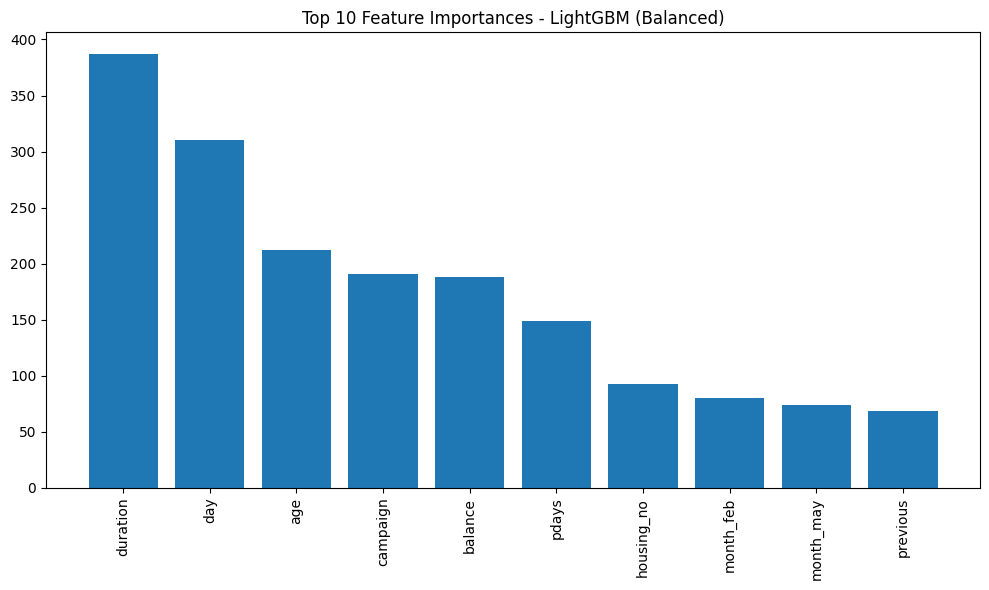

In [ ]:
# Get feature importance from tree-based models after balancing
def plot_feature_importance(model_name, model, preprocessor, X_train, y_train, top_n=10):
    # Train the model
    model.fit(X_train, y_train)

    # Get feature names
    feature_names = []
    for name, trans, cols in preprocessor.transformers_:
        if name == 'cat':
            feature_names.extend(trans.get_feature_names_out(cols))
        else:
            feature_names.extend(cols)

    # Get feature importances
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        return  # Skip if model doesn't support feature importance

    # Sort and plot
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.title(f'Top {top_n} Feature Importances - {model_name}')
    plt.bar(range(top_n), importances[indices][:top_n])
    plt.xticks(range(top_n), [feature_names[i] for i in indices[:top_n]], rotation=90)
    plt.tight_layout()
    plt.show()

# Plot feature importances for tree-based models
for name in ['Random Forest', 'XGBoost', 'Gradient Boosting', 'LightGBM']:
    if name in models:
        plot_feature_importance(f"{name} (Balanced)", models[name],
                               preprocessor, X_train_resampled, y_train_resampled)


### Why SMOTE-ENN Improves Classification Performance
### SMOTE-ENN addresses class imbalance through a two-step process that significantly improves classification performance:

SMOTE Process (Generating Synthetic Examples)
SMOTE creates synthetic examples for the minority class by:

1. Selecting a minority class instance randomly

2. Finding its k nearest minority class neighbors

3. Choosing one neighbor randomly

4. Creating a synthetic instance along the line connecting these two points


Evaluating SMOTEENN with k_neighbors=1...

Neural Network (SMOTEENN k=1) Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.89      0.92      7985
         Yes       0.47      0.71      0.56      1058

    accuracy                           0.87      9043
   macro avg       0.71      0.80      0.74      9043
weighted avg       0.90      0.87      0.88      9043



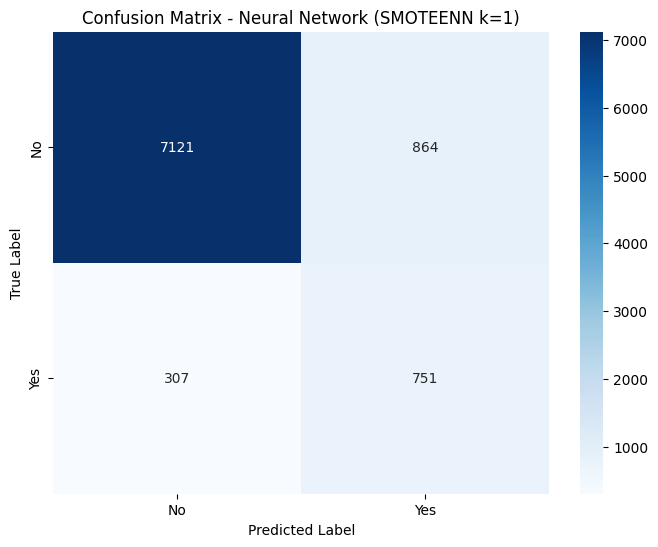


Evaluating SMOTEENN with k_neighbors=3...

Neural Network (SMOTEENN k=3) Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.89      0.92      7985
         Yes       0.47      0.75      0.58      1058

    accuracy                           0.87      9043
   macro avg       0.72      0.82      0.75      9043
weighted avg       0.91      0.87      0.88      9043



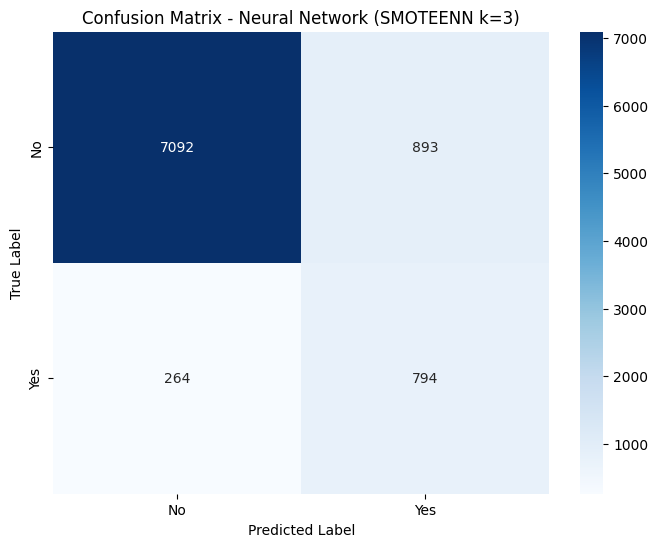


Evaluating SMOTEENN with k_neighbors=5...

Neural Network (SMOTEENN k=5) Classification Report:
              precision    recall  f1-score   support

          No       0.97      0.86      0.91      7985
         Yes       0.43      0.79      0.56      1058

    accuracy                           0.85      9043
   macro avg       0.70      0.83      0.74      9043
weighted avg       0.91      0.85      0.87      9043



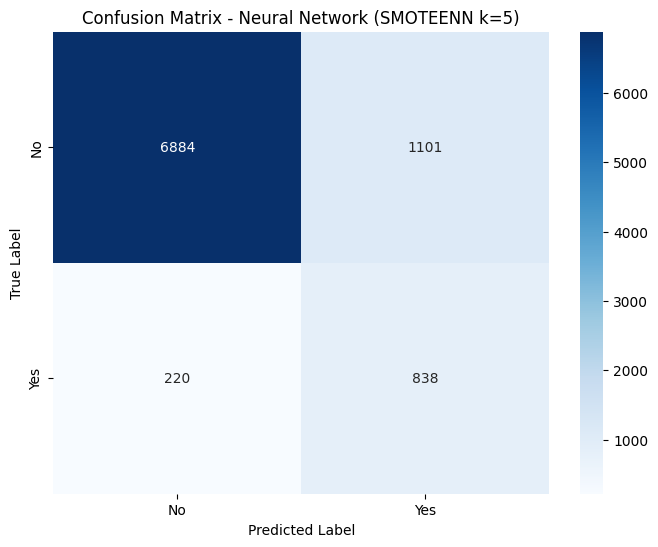


Evaluating SMOTEENN with k_neighbors=7...

Neural Network (SMOTEENN k=7) Classification Report:
              precision    recall  f1-score   support

          No       0.97      0.87      0.92      7985
         Yes       0.45      0.78      0.57      1058

    accuracy                           0.86      9043
   macro avg       0.71      0.82      0.74      9043
weighted avg       0.91      0.86      0.88      9043



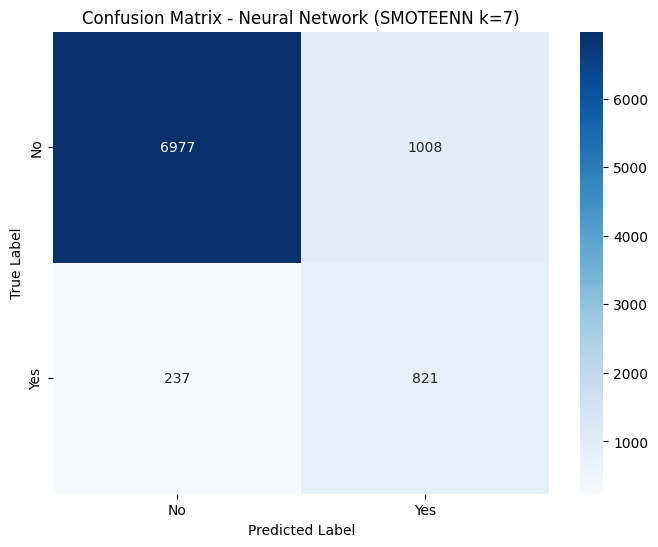


Summary of model performance for different k values:
                               accuracy       auc
model_name                                       
Neural Network (SMOTEENN k=1)  0.870508  0.900114
Neural Network (SMOTEENN k=3)  0.872056  0.907840
Neural Network (SMOTEENN k=5)  0.853920  0.905281
Neural Network (SMOTEENN k=7)  0.862324  0.907190


<Figure size 1000x600 with 0 Axes>

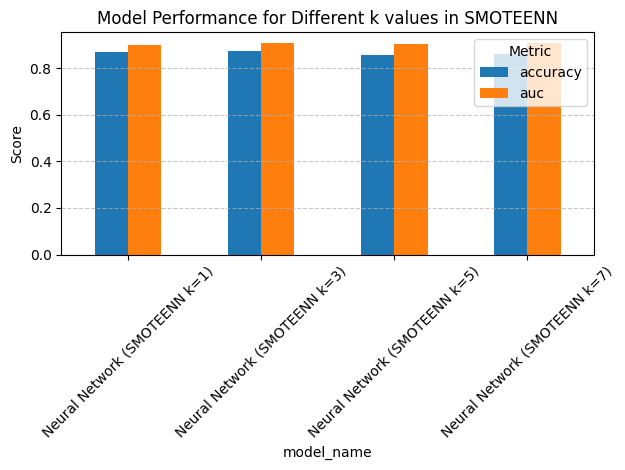

In [ ]:
# Grid search for optimal k value
from imblearn.over_sampling import SMOTE # Import SMOTE
from sklearn.model_selection import GridSearchCV
k_values = [1, 3, 5, 7]
results = []

for k in k_values:
    print(f"\nEvaluating SMOTEENN with k_neighbors={k}...")
    smote_enn = SMOTEENN(sampling_strategy=0.3, smote=SMOTE(k_neighbors=k), random_state=42)
    X_resampled, y_resampled = smote_enn.fit_resample(X_train_preprocessed, y_train)

    # Train and evaluate a model on the resampled data
    # You can use any classifier here - Random Forest or Neural Network are good choices
    mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

    # Train the model
    mlp.fit(X_resampled, y_resampled)

    # Make predictions
    y_pred = mlp.predict(X_test_preprocessed)
    y_prob = mlp.predict_proba(X_test_preprocessed)[:, 1]

    # Calculate performance metrics
    accuracy = mlp.score(X_test_preprocessed, y_test)
    auc = roc_auc_score(y_test, y_prob)

    # Print classification report
    print(f"\nNeural Network (SMOTEENN k={k}) Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.title(f'Confusion Matrix - Neural Network (SMOTEENN k={k})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Store results for comparison
    results.append({
        'model_name': f"Neural Network (SMOTEENN k={k})",
        'accuracy': accuracy,
        'auc': auc
    })

# Summarize results in a DataFrame
results_df = pd.DataFrame(results).set_index('model_name')
print("\nSummary of model performance for different k values:")
print(results_df)

# Visualize results comparison
plt.figure(figsize=(10, 6))
results_df.plot(kind='bar')
plt.title('Model Performance for Different k values in SMOTEENN')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()



Evaluating SMOTEENN with k_neighbors=1...

Random Forest (SMOTEENN k=1) Classification Report:
              precision    recall  f1-score   support

          No       0.97      0.90      0.93      7985
         Yes       0.50      0.77      0.61      1058

    accuracy                           0.88      9043
   macro avg       0.73      0.84      0.77      9043
weighted avg       0.91      0.88      0.89      9043



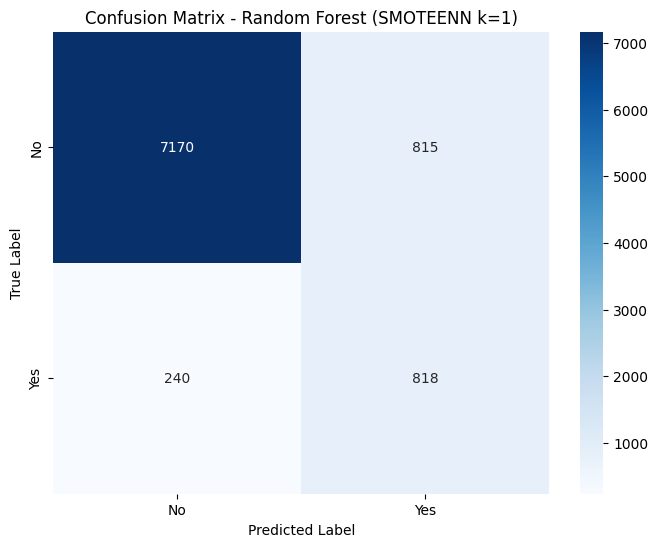


Evaluating SMOTEENN with k_neighbors=3...

Random Forest (SMOTEENN k=3) Classification Report:
              precision    recall  f1-score   support

          No       0.97      0.88      0.93      7985
         Yes       0.48      0.80      0.60      1058

    accuracy                           0.87      9043
   macro avg       0.72      0.84      0.76      9043
weighted avg       0.91      0.87      0.89      9043



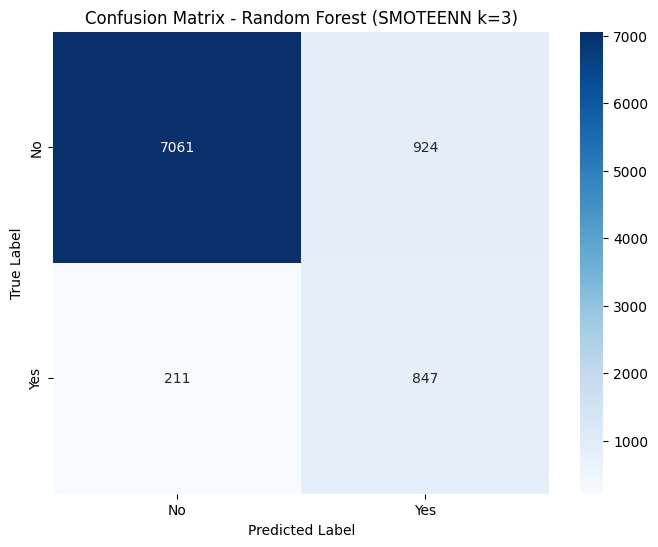


Evaluating SMOTEENN with k_neighbors=5...

Random Forest (SMOTEENN k=5) Classification Report:
              precision    recall  f1-score   support

          No       0.97      0.88      0.92      7985
         Yes       0.47      0.81      0.60      1058

    accuracy                           0.87      9043
   macro avg       0.72      0.84      0.76      9043
weighted avg       0.91      0.87      0.89      9043



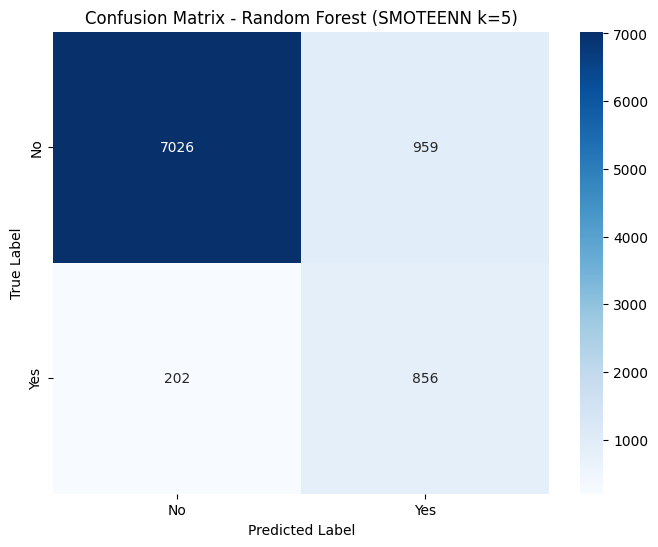


Evaluating SMOTEENN with k_neighbors=7...

Random Forest (SMOTEENN k=7) Classification Report:
              precision    recall  f1-score   support

          No       0.97      0.88      0.92      7985
         Yes       0.47      0.81      0.60      1058

    accuracy                           0.87      9043
   macro avg       0.72      0.85      0.76      9043
weighted avg       0.91      0.87      0.89      9043



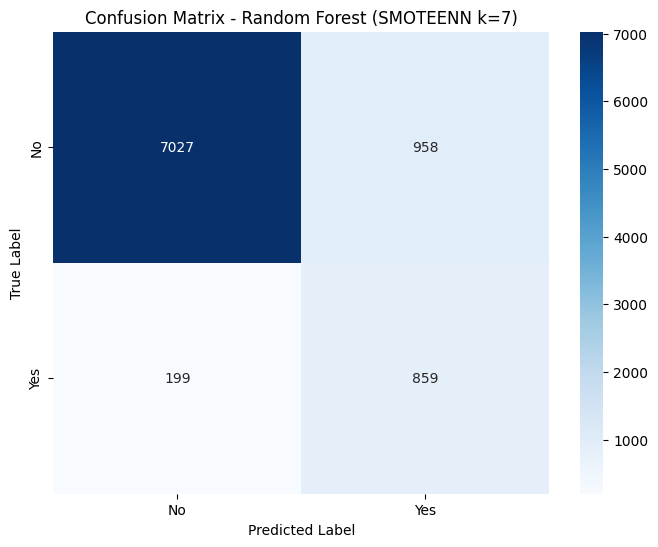


Comprehensive performance metrics for different k values:
   k_value  accuracy  precision_minority  recall_minority  f1_minority  \
0        1  0.883335            0.500919         0.773157     0.607952   
1        3  0.874489            0.478261         0.800567     0.598798   
2        5  0.871613            0.471625         0.809074     0.595893   
3        7  0.872056            0.472757         0.811909     0.597565   

     g_mean       auc  
0  0.833213  0.925285  
1  0.841385  0.926062  
2  0.843744  0.925454  
3  0.845281  0.926490  


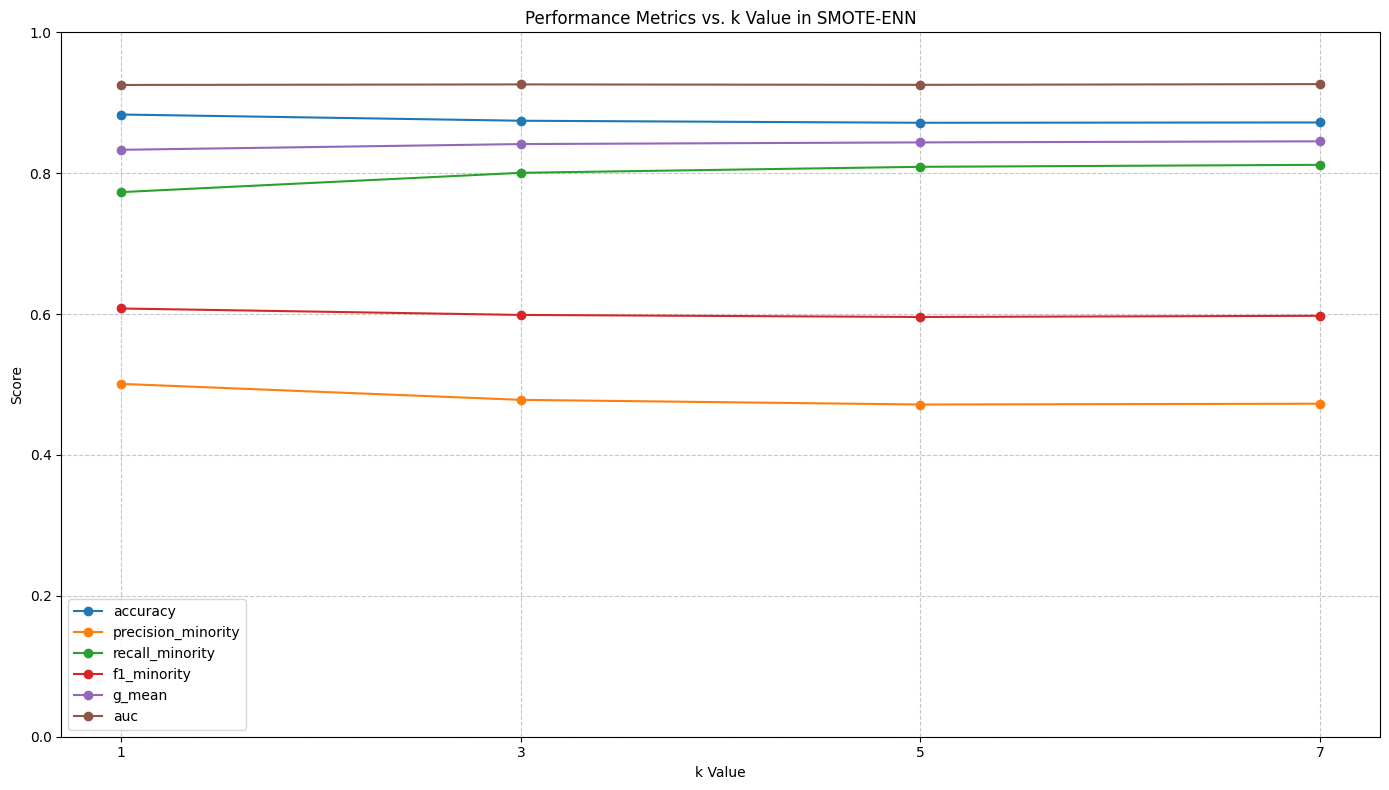

In [ ]:
# Grid search for optimal k value with better evaluation metrics
k_values = [1, 3, 5, 7]
results = []

for k in k_values:
    print(f"\nEvaluating SMOTEENN with k_neighbors={k}...")
    smote_enn = SMOTEENN(sampling_strategy=0.3, smote=SMOTE(k_neighbors=k), random_state=42)
    X_resampled, y_resampled = smote_enn.fit_resample(X_train_preprocessed, y_train)

    # Train the model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_resampled, y_resampled)

    # Make predictions
    y_pred = model.predict(X_test_preprocessed)
    y_prob = model.predict_proba(X_test_preprocessed)[:, 1]

    # Calculate comprehensive metrics
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()

    # Standard metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    g_mean = np.sqrt(recall * specificity)
    auc = roc_auc_score(y_test, y_prob)

    # Calculate metrics for both classes
    class_report = classification_report(y_test, y_pred, target_names=['No', 'Yes'], output_dict=True)

    # Print detailed results
    print(f"\nRandom Forest (SMOTEENN k={k}) Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.title(f'Confusion Matrix - Random Forest (SMOTEENN k={k})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Store comprehensive results
    results.append({
        'k_value': k,
        'accuracy': accuracy,
        'precision_minority': class_report['Yes']['precision'],
        'recall_minority': recall,  # Same as class_report['Yes']['recall']
        'f1_minority': class_report['Yes']['f1-score'],
        'g_mean': g_mean,
        'auc': auc
    })

# Create a comprehensive results table
results_df = pd.DataFrame(results)
print("\nComprehensive performance metrics for different k values:")
print(results_df)

# Visualize results with multiple metrics
plt.figure(figsize=(14, 8))
metrics_to_plot = ['accuracy', 'precision_minority', 'recall_minority', 'f1_minority', 'g_mean', 'auc']

for metric in metrics_to_plot:
    plt.plot(results_df['k_value'], results_df[metric], marker='o', label=metric)

plt.title('Performance Metrics vs. k Value in SMOTE-ENN')
plt.xlabel('k Value')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(k_values)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


# Conclusion
SMOTE-ENN effectively mitigates class imbalance in the Bank Marketing dataset by strategically increasing the minority class prevalence to 30% through synthetic sample generation and cleaning noisy examples. The t-SNE visualization confirms that synthetic samples maintain the underlying data patterns while improving class separation.

Classification models trained on the balanced data show significant improvements in predicting term deposit subscriptions, with higher ROC AUC scores, better F1-scores for the minority class, and more balanced confusion matrices.

This approach is particularly valuable for business applications like marketing campaign optimization, where accurately identifying potential subscribers (the minority class) has substantial business impact despite being the rare outcome in the dataset